<a href="https://colab.research.google.com/github/suri-pu-bi/baekjoon_study/blob/main/knn_%EB%86%8D%EA%B5%AC%EC%84%A0%EC%88%98_%ED%8F%AC%EC%A7%80%EC%85%98_%EC%98%88%EC%B8%A1_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Dataset (학습 데이터, 테스트 데이터)

In [15]:
# # csv 파일로부터 데이터 수집
# df = pd.read_csv("./basketball_stat.csv")
# print(df)

In [16]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
df = pd.read_csv('./basketball_stat.csv')

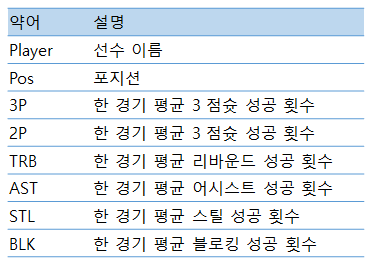

In [19]:
# 현재 가지고 있는 데이터에서 포지션 개수 확인
df.Pos.value_counts()

C     50
SG    50
Name: Pos, dtype: int64

#필요한 속성

C -> 센터, TRB BLK

SG -> 슈팅가드, 3P

In [20]:
# 분별력이 없는 특징(feature) 데이터로부터 제거
df.drop(['2P', 'AST', 'STL'], axis=1, inplace = True)
print(df)

              Player Pos   3P   TRB  BLK
0       Alex Abrines  SG  1.4   1.3  0.1
1       Steven Adams   C  0.0   7.7  1.0
2      Alexis Ajinca   C  0.0   4.5  0.6
3     Chris Andersen   C  0.0   2.6  0.6
4        Will Barton  SG  1.5   4.3  0.5
..               ...  ..  ...   ...  ...
95    Nikola Vucevic   C  0.3  10.4  1.0
96       Dwyane Wade  SG  0.8   4.5  0.7
97      Dion Waiters  SG  1.8   3.3  0.4
98  Hassan Whiteside   C  0.0  14.1  2.1
99      Lou Williams  SG  2.0   2.5  0.2

[100 rows x 5 columns]


In [21]:
from sklearn.model_selection import train_test_split

# 20%를 테스트 데이터로 분류
train, test = train_test_split(df, test_size=0.2)

In [22]:
# 학습 데이터의 개수 확인
train.shape[0]

80

In [23]:
# 테스트 데이터의 개수 확인
test.shape[0]

20

In [24]:
import pickle
with open('./basketball_train.pkl', 'wb') as train_data:
    pickle.dump(train, train_data)
    
with open('./basketball_test.pkl', 'wb') as test_data:
    pickle.dump(test, test_data)

In [25]:
with open('./basketball_train.pkl', 'rb') as train_data:
    train = pickle.load(train_data)
    
with open('./basketball_test.pkl', 'rb') as test_data:
    test = pickle.load(test_data)

# 최적의 k 찾기 (교차 검증 - cross validation)

In [26]:
# import kNN library
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# find best k, range from 3 to half of the number of data (k -> 3~40)
max_k_range = train.shape[0] // 2
k_list = []
for i in range(3, max_k_range, 2):
    k_list.append(i)
 
cross_validation_scores = []
x_train = train[['3P', 'BLK' , 'TRB']]
y_train = train[['Pos']]

# 10-fold cross validation
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train.values.ravel(),
                             cv=10, scoring='accuracy')
    cross_validation_scores.append(scores.mean())

cross_validation_scores

[0.9375,
 0.9125,
 0.925,
 0.9125,
 0.925,
 0.9125,
 0.9125,
 0.9125,
 0.9125,
 0.9125,
 0.8875,
 0.8875,
 0.875,
 0.875,
 0.875,
 0.8375,
 0.85,
 0.825,
 0.8125]

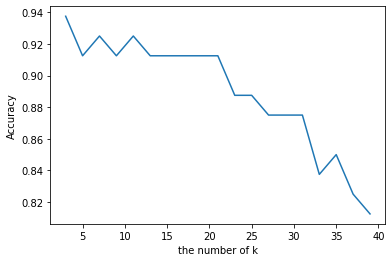

In [27]:
# visualize accuracy according to k
plt.plot(k_list, cross_validation_scores)
plt.xlabel('the number of k')
plt.ylabel('Accuracy')
plt.show()

In [28]:
# find best k
cvs = cross_validation_scores
k = k_list[cvs.index(max(cross_validation_scores))]
print("The best number of k : " + str(k) )

The best number of k : 3


# 2개의 특징으로 예측하기 (3점슛, 블로킹)

In [29]:
# import libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=k)

# select data features
x_train = train[['3P', 'BLK']]
# select target value
y_train = train[['Pos']]

# setup knn using train data
knn.fit(x_train, y_train.values.ravel())

# select data feature to be used for prediction
x_test = test[['3P', 'BLK']]

# select target value
y_test = test[['Pos']]

# test
pred = knn.predict(x_test)

In [30]:
# check ground_truth with knn prediction
comparison = pd.DataFrame(
    {'prediction':pred, 'ground_truth':y_test.values.ravel()}) 
comparison

,prediction,ground_truth
0,C,C
1,SG,SG
2,SG,SG
3,C,C
4,SG,SG
5,SG,SG
6,SG,SG
7,SG,C
8,SG,SG
9,SG,SG


In [31]:
# check accuracy
print("accuracy : "+ 
          str(accuracy_score(y_test.values.ravel(), pred)) )

accuracy : 0.9


# 3개의 특징으로 예측하기 (3점슛, 블로킹, 리바운드)

In [32]:
knn = KNeighborsClassifier(n_neighbors=k)

# select data features to be used in train
x_train = train[['3P', 'BLK', 'TRB']]
# select target
y_train = train[['Pos']]

# build knn model
knn.fit(x_train, y_train.values.ravel())

# select features to be used for prediction
x_test = test[['3P', 'BLK', 'TRB']]

# select target
y_test = test[['Pos']]

# test
pred = knn.predict(x_test)

In [33]:
# check ground_truth with knn prediction
comparison = pd.DataFrame(
    {'prediction':pred, 'ground_truth':y_test.values.ravel()}) 
comparison

,prediction,ground_truth
0,C,C
1,SG,SG
2,SG,SG
3,C,C
4,SG,SG
5,SG,SG
6,SG,SG
7,SG,C
8,SG,SG
9,SG,SG


In [34]:
# check accuracy
print("accuracy : " + 
          str( accuracy_score(y_test.values.ravel(), pred)) )

accuracy : 0.9
